In [5]:
import pdb
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.cm as cm
import matplotlib.colors as colors

from dca.methods_comparison import JPCA
#from pyuoi.linear_model.var  import VAR
from neurosim.models.var import form_companion

sys.path.append('/home/marcush/projects/neural_control/')
sys.path.append('/home/marcush/projects/neural_control/analysis_scripts/')
sys.path.append('/home/marcush/projects/github_repos')
from utils import apply_df_filters, calc_loadings, calc_cascaded_loadings
from loaders import load_sabes
from decoders import lr_decoder
from segmentation import reach_segment_sabes, measure_straight_dev

from psth_ilmerge import get_top_neurons, get_top_neurons_alt

In [6]:
def get_scalar(df_, stat, neu_idx):

    if stat == 'decoding_weights':
        if 'decoding_window' in df_.iloc[0]['decoder_params'].keys():
            decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
            c = calc_loadings(df_.iloc[0]['decoding_weights'][2:4].T, d=decoding_win)[neu_idx]
        else:
            c = calc_loadings(df_.iloc[0]['decoding_weights'][2:4].T)[neu_idx]

    elif stat == 'encoding_weights':
        if 'decoding_window' in df_.iloc[0]['decoder_params'].keys():
            decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
            c =  calc_loadings(df_.iloc[0]['encoding_weights'], d=decoding_win)[neu_idx]    
        else:
            c =  calc_loadings(df_.iloc[0]['encoding_weights'])[neu_idx]    

    elif stat in ['su_r2_pos', 'su_r2_vel', 'su_r2_enc', 'su_var', 'su_act', 'su_decoding_r2', 'su_encoding_r2']:
        c = df_.iloc[0][stat][neu_idx]  

    elif stat == 'orientation_tuning':
        c = np.zeros(8)
        for j in range(8):
            c[j] = df_.loc[df_['bin_idx'] == j].iloc[0]['tuning_r2'][j, 2, neu_idx]
        c = np.mean(c)
        # c = odf_.iloc[0]

    return c

In [7]:
region = 'AM'
DIM = 21
figpath = './'


# Load Dataframe(s)
dataframe_path = '/home/marcush/Data/TsaoLabData/neural_control_output_new/decoding_deg_230322_214006_Jamie/decoding_deg_230322_214006_Jamie_glom.pickle'
with open(dataframe_path, 'rb') as f:
    rl = pickle.load(f)
dimreduc_df = pd.DataFrame(rl)

# Set args for psth_ilmerge.py
data_path = dimreduc_df['data_path'][0]

bin_width = dimreduc_df['loader_args'][0]['bin_width']

# Filter dataset approproately and attain appropriate structure
#dimreduc_df = pd.concat([indy_df, loco_df])

top_neurons_df, loadings_df = get_top_neurons(dimreduc_df, method1='FCCA', method2='PCA', T=3, n=5, pairwise_exclude=False, data_path=data_path, bin_width=bin_width, region=region)


1it [00:00, 39.20it/s]
1it [00:00, 72.39it/s]


In [12]:
su_calcs_path = f'{os.path.dirname(dataframe_path)}/tsao_su_calcs.dat'
with open(su_calcs_path, 'rb') as f:
    tsao_su_stats = pickle.load(f)

tsao_su_df = pd.DataFrame(tsao_su_stats)

# Dimensionality selection
itrim_df = loadings_df
data_files = np.unique(itrim_df['data_file'].values)

# Collect the desired single unit statistics into an array with the same ordering as those present in the loadings df
stats = ['su_var', 'su_act', 'decoding_weights', 'su_encoding_r2']


carray = []
for i, data_file in enumerate(data_files):
    df = apply_df_filters(itrim_df, data_file=data_file)
    carray_ = np.zeros((df.shape[0], len(stats)))
    for j in range(df.shape[0]):                    # Find the correlaton between 
        for k, stat in enumerate(stats):
            
            # Grab the unique identifiers needed
            nidx = df.iloc[j]['nidx']
            df_ = apply_df_filters(tsao_su_df, data_file=data_file)
            carray_[j, k] = get_scalar(df_, stat, nidx)
    carray.append(carray_)

su_r = np.zeros((len(carray), 2, carray[0].shape[1]))
keys = ['FCCA_loadings', 'PCA_loadings']


In [19]:
p = range(df.shape[0])[-1]
df.iloc[p]['nidx']

269

/tmp/ipykernel_93717/1547339528.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  su_r[i, j, k] = scipy.stats.spearmanr(x1, x2)[0]
/tmp/ipykernel_93717/1547339528.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  su_r[i, j, k] = scipy.stats.spearmanr(x1, x2)[0]


Wilcoxon p-value for leverage socre prediction: 0.500000
1.5


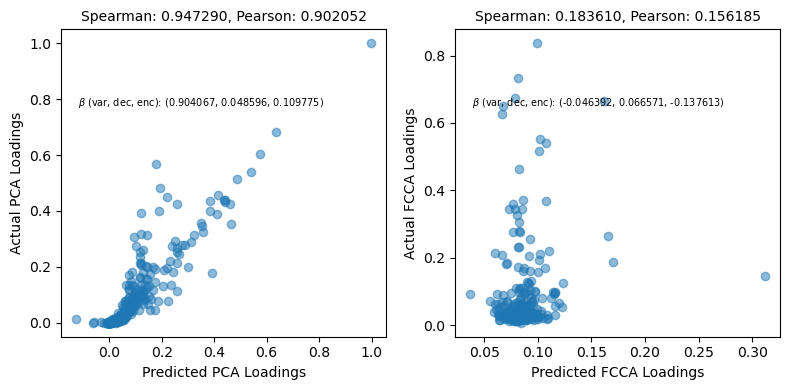

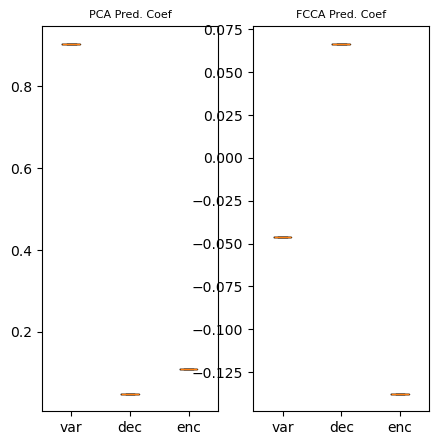

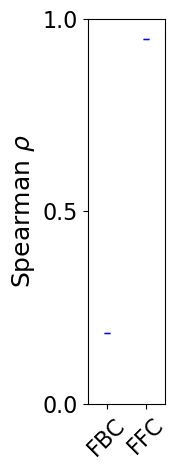

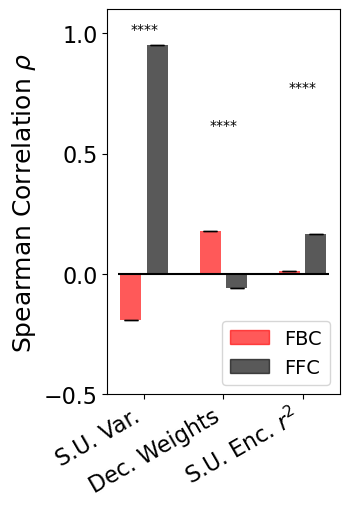

In [11]:
X = []
Yf = []
Yp = []

# Per recording session
x_ = []
yf_ = []
yp_ = []

for i in range(len(carray)):
    for j in range(2):
        df = apply_df_filters(itrim_df, data_file=data_files[i])
        x1 = df[keys[j]].values

        if j == 0:
            Yf.extend(x1)
            yf_.append(x1)
        else:
            Yp.extend(x1)
            yp_.append(x1)

        xx = []

        for k in range(carray[0].shape[1]):
            x2 = carray[i][:, k]
            xx.append(x2)
            su_r[i, j, k] = scipy.stats.spearmanr(x1, x2)[0]
    
        xx = np.array(xx).T            
    X.append(xx)
    x_.append(xx)


X = np.vstack(X)
Yf = np.array(Yf)[:, np.newaxis]
Yp = np.array(Yp)[:, np.newaxis]
assert(X.shape[0] == Yf.shape[0])
assert(X.shape[0] == Yp.shape[0])

# Train a linear model to predict loadings from the single unit statistics and then assess the spearman correlation between predicted and actual loadings

r1p_ = []
r1f_ = []
coefp = []
coeff = []

rpcv = []
rfcv = []

# Do not include autocorrelation times

for i in range(len(carray)):

    linmodel = LinearRegression().fit(x_[i][:, [0, 2, 3]], np.array(yp_[i])[:, np.newaxis])
    linmodel2 = LinearRegression().fit(x_[i][:, [0, 2, 3]], np.array(yf_[i])[:, np.newaxis])

    yp_pred = linmodel.predict(x_[i][:, [0, 2, 3]])
    yf_pred = linmodel2.predict(x_[i][:, [0, 2, 3]])

    # get normalized coefficients for feature importance assessment
    x__ = StandardScaler().fit_transform(x_[i][:, [0, 2, 3]])
    y__ = StandardScaler().fit_transform(np.array(yp_[i])[:, np.newaxis])

    linmodel = LinearRegression().fit(x__, y__)
    coefp.append(linmodel.coef_.squeeze())

    y__ = StandardScaler().fit_transform(np.array(yf_[i])[:, np.newaxis])
    linmodel = LinearRegression().fit(x__, y__)
    coeff.append(linmodel.coef_.squeeze())

    # Try cross-validation
    rpcv.append(np.mean(cross_val_score(LinearRegression(), x_[i][:, [0, 2, 3]], np.array(yp_[i])[:, np.newaxis], cv=5)))
    rfcv.append(np.mean(cross_val_score(LinearRegression(), x_[i][:, [0, 2, 3]], np.array(yf_[i])[:, np.newaxis], cv=5)))

    #r1p_.append(scipy.stats.spearmanr(yp_pred.squeeze(), np.array(yp_[i]).squeeze())[0])
    #r1f_.append(scipy.stats.spearmanr(yf_pred.squeeze(), np.array(yf_[i]).squeeze())[0])
    r1p_.append(scipy.stats.spearmanr(yp_pred.squeeze(), np.array(yp_[i]).squeeze())[0])
    r1f_.append(scipy.stats.spearmanr(yf_pred.squeeze(), np.array(yf_[i]).squeeze())[0])

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].scatter(yp_pred.squeeze(), np.array(yp_[i]).squeeze(), alpha=0.5)
    ax[1].scatter(yf_pred.squeeze(), np.array(yf_[i]).squeeze(), alpha=0.5)
    ax[0].set_title('Spearman: %f, Pearson: %f' % (r1p_[i], scipy.stats.pearsonr(yp_pred.squeeze(), np.array(yp_[i]).squeeze())[0]), fontsize=10)
    ax[1].set_title('Spearman: %f, Pearson: %f' % (r1f_[i], scipy.stats.pearsonr(yf_pred.squeeze(), np.array(yf_[i]).squeeze())[0]), fontsize=10)

    ax[0].set_xlabel('Predicted PCA Loadings', fontsize=10)
    ax[0].set_ylabel('Actual PCA Loadings', fontsize=10)

    ax[1].set_xlabel('Predicted FCCA Loadings', fontsize=10)
    ax[1].set_ylabel('Actual FCCA Loadings', fontsize=10)

    ax[0].annotate(r'$\beta$ '  + '(var, dec, enc): (%f, %f, %f)' % tuple(coefp[i]), (0.05, 0.75), xycoords='axes fraction', fontsize=7)
    ax[1].annotate(r'$\beta$ '  + '(var, dec, enc): (%f, %f, %f)' % tuple(coeff[i]), (0.05, 0.75), xycoords='axes fraction', fontsize=7)


    #fig.savefig('/home/akumar/nse/neural_control/figs/su_figs_debug/%i_noact.pdf' % i, bbox_inches='tight', pad_inches=0)
    fig.tight_layout()

stats, p = scipy.stats.wilcoxon(r1p_, r1f_, alternative='greater')
print('Wilcoxon p-value for leverage socre prediction: %f' % p)



# Make a boxplot of the coefficients
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

ax[0].boxplot(np.array(coefp), showfliers=False)
ax[1].boxplot(np.array(coeff), showfliers=False)
ax[0].set_title('PCA Pred. Coef', fontsize=8)
ax[1].set_title('FCCA Pred. Coef', fontsize=8)

# No act
ax[0].set_xticklabels(['var', 'dec', 'enc'])
ax[1].set_xticklabels(['var', 'dec', 'enc'])

#fig.savefig('/home/akumar/nse/neural_control/figs/su_figs_debug/coef_boxplot_noact.pdf', bbox_inches='tight', pad_inches=0)

# Make a boxplot out of it
fig, ax = plt.subplots(1, 1, figsize=(1, 5))
medianprops = dict(linewidth=1, color='b')
whiskerprops = dict(linewidth=0)
bplot = ax.boxplot([r1f_, r1p_], patch_artist=True,
                medianprops=medianprops, notch=False, showfliers=False, whiskerprops=whiskerprops, showcaps=False)
ax.set_xticklabels(['FBC', 'FFC'], rotation=45)
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel('Spearman ' + r'$\rho$', fontsize=18)

colors = ['r', 'k']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/iscore_prediction_boxplot_noact.pdf', bbox_inches='tight', pad_inches=0)


#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/iscore_prediction_boxplot_noact_grant.pdf', bbox_inches='tight', pad_inches=0)

linmodel1 = LinearRegression().fit(X, Yp)
linmodel2 = LinearRegression().fit(X, np.log10(Yp))

Yp_pred1 = linmodel1.predict(X)
Yp_pred2 = linmodel2.predict(X)

r1p = scipy.stats.spearmanr(Yp_pred1.squeeze(), Yp.squeeze())[0]
r2p = scipy.stats.spearmanr(Yp_pred2.squeeze(), Yp.squeeze())[0]

linmodel1 = LinearRegression().fit(X, Yf)
linmodel2 = LinearRegression().fit(X, np.log10(Yf))

Yf_pred1 = linmodel1.predict(X)
Yf_pred2 = linmodel2.predict(X)

r1f = scipy.stats.spearmanr(Yf_pred1.squeeze(), Yf.squeeze())[0]
r2f = scipy.stats.spearmanr(Yf_pred2.squeeze(), Yf.squeeze())[0]

#print(r1p)
#print(r1f)
# linmodel = LinearRegression().fit(su_r[])

# linmodel = LinearRegression().fit()


fig, ax = plt.subplots(figsize=(3, 5),)


# Prior to averaging, run tests. 

# Updated for multiple comparisons adjustment. 
_, p1 = scipy.stats.wilcoxon(su_r[:, 0, 0], su_r[:, 1, 0], alternative='less')
_, p2 = scipy.stats.wilcoxon(su_r[:, 0, 1], su_r[:, 1, 1], alternative='less')
_, p3 = scipy.stats.wilcoxon(su_r[:, 0, 2], su_r[:, 1, 2], alternative='less')
_, p4 = scipy.stats.wilcoxon(su_r[:, 0, 3], su_r[:, 1, 3], alternative='less')

# sort
pvec = np.sort([p1, p3, p4])
# Sequentially test and determine the minimum significance level
# a1 = pvec[0] * 4
a1 = pvec[0] * 3
a2 = pvec[1] * 2
a3 = pvec[2]
#pdb.set_trace()
print(max([a1, a2, a3]))   

std_err = np.std(su_r, axis=0).ravel()/np.sqrt(35)
su_r = np.mean(su_r, axis=0).ravel()

# Permute so that each statistic is next to each other
# No ACT
su_r = su_r[[0, 4, 2, 6, 3, 7]]
std_err = std_err[[0, 4, 2, 6, 3, 7]]

bars = ax.bar([0, 1, 3, 4, 6, 7],
                su_r,
                color=['r', 'k', 'r', 'k', 'r', 'k'], alpha=0.65,
                yerr=std_err, capsize=5)

# Place numerical values above the bars

ax.text(0.5, 1.0, '****', ha='center')
ax.text(3.5, 0.6, '****', ha='center')
ax.text(6.5, 0.76, '****', ha='center')


ax.set_ylim([-0.5, 1.1])
ax.set_xticks([0.5, 3.5, 6.5])

ax.set_xticklabels(['S.U. Var.', 'Dec. Weights', 'S.U. Enc. ' + r'$r^2$'], rotation=30, fontsize=12, ha='right')


# Manual creation of legend
colors = ['r', 'k']
handles = [plt.Rectangle((0,0),1,1, color=c, alpha=0.65) for c in colors]
labels = ['FBC', 'FFC']
ax.legend(handles, labels, loc='lower right', prop={'size': 14})

ax.set_ylabel('Spearman Correlation ' + r'$\rho$', fontsize=18)
ax.set_yticks([-0.5, 0, 0.5, 1.])
ax.tick_params(axis='both', labelsize=16)

# Horizontal line at 0
ax.hlines(0, -0.5, 7.5, color='k')

#fig.savefig('%s/su_spearman_d%d.pdf' % (figpath, DIM), bbox_inches='tight', pad_inches=0)